In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

C:\Users\Eyal\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
path = 'C:/Users/Eyal/Desktop/causal inference/project/tennis/'
original_data = pd.read_csv(path + 'data.csv').drop(['Player'], axis=1)
treated = original_data[original_data['T'] == 1]
not_treated = original_data[original_data['T'] == 0]
data = pd.get_dummies(original_data, prefix=['Surface', 'Court', 'Best of'], columns=['Surface', 'Court', 'Best of'])
data.head()

,Rank,Age,weight_kg,height_cm,experience,T,Y,Surface_Carpet,Surface_Clay,Surface_Grass,Surface_Hard,Court_Indoor,Court_Outdoor,Best of_3,Best of_5
0,40.0,24.0,70.0,185.0,5.0,1,1,0,0,0,1,0,1,1,0
1,34.0,24.0,70.0,185.0,5.0,0,1,0,0,0,1,0,1,0,1
2,18.0,24.0,70.0,185.0,5.0,1,1,0,0,1,0,0,1,1,0
3,29.0,26.0,70.0,185.0,7.0,1,1,1,0,0,0,1,0,1,0
4,48.0,26.0,70.0,185.0,7.0,1,1,1,0,0,0,1,0,1,0


In [3]:
print(len(data))

3138


In [4]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from matplotlib import pyplot as plt
# corr = original_data.corr().round(3)
# sns.heatmap(corr, cmap="Blues", annot=True)
# plt.show()

corr = original_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,Rank,Best of,Age,weight_kg,height_cm,experience,T,Y
Rank,1.000,-0.010,0.003,-0.020,0.005,-0.064,-0.018,-0.014
Best of,-0.010,1.000,0.012,-0.013,-0.013,0.015,0.002,0.021
Age,0.003,0.012,1.000,-0.014,-0.021,0.928,0.013,-0.017
weight_kg,-0.020,-0.013,-0.014,1.000,0.804,-0.086,-0.001,0.023
height_cm,0.005,-0.013,-0.021,0.804,1.000,-0.086,-0.006,0.017
experience,-0.064,0.015,0.928,-0.086,-0.086,1.000,0.015,-0.008
T,-0.018,0.002,0.013,-0.001,-0.006,0.015,1.000,0.189
Y,-0.014,0.021,-0.017,0.023,0.017,-0.008,0.189,1.000


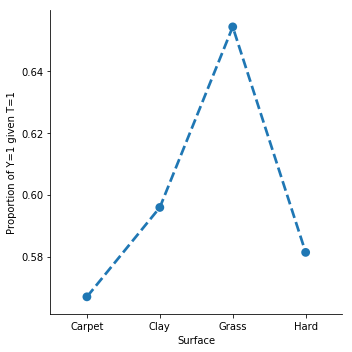

In [5]:
import seaborn as sns

df1 = original_data[original_data['T'] == 1].groupby('Surface', as_index = False).sum()
df1.head()
df1['Proportion of Y=1 given T=1'] = df1['Y'] / df1['T']
sns.catplot(x="Surface", y='Proportion of Y=1 given T=1', kind="point", data=df1, linestyles=["--"])

In [6]:
def plot_e(data, clf):
    treated, not_treated = data[data['T'] == 1], data[data['T'] == 0]
    e1 = get_e(treated, clf)
    e0 = get_e(not_treated, clf)

    plt.hist(e0, bins=50)
    plt.hist(e1, bins=50)
    plt.legend(['Not Treatred', 'Treated'])
    plt.xlabel('Propensity Scores')
    plt.ylabel('Count')
    plt.show()
    

In [7]:
def get_X_t_y(df):
    X, t, y = df.drop(['Y', 'T'], axis=True).to_numpy(), df['T'].to_numpy(), df['Y'].to_numpy()
    return X, t, y   

def get_e(data, clf):
    X, t, y = get_X_t_y(data)
    e = clf.predict_proba(X)[:, 1]
    return e

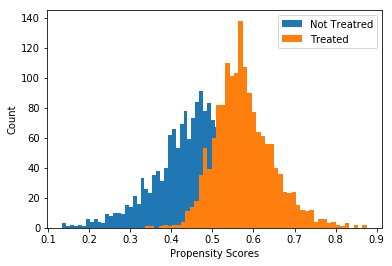

In [8]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

clf =  RandomForestClassifier(max_depth=10)

X, t, y = get_X_t_y(data)
clf.fit(X, t)

plot_e(data, clf)

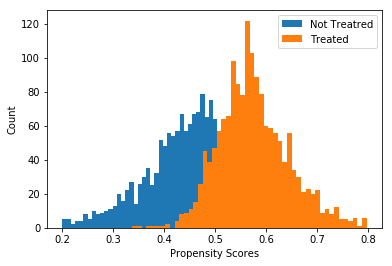

In [9]:
e = get_e(data, clf)
take = [i for i in range(len(e)) if 0.2 < e[i] < 0.8]
data = data.iloc[take]
plot_e(data, clf)

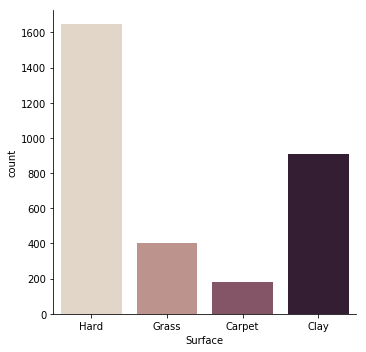

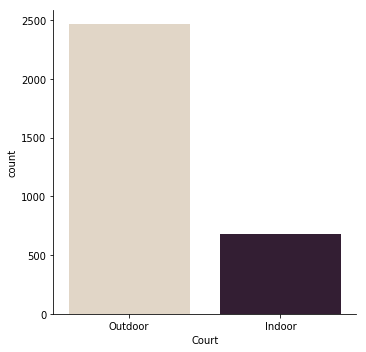

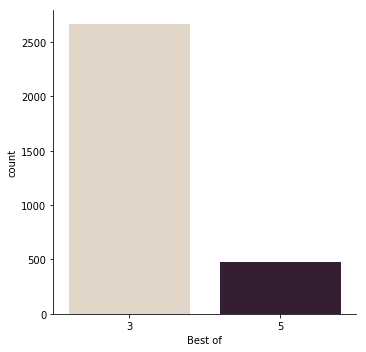

In [10]:
import seaborn as sns


sns.catplot(x="Surface", kind="count", palette="ch:.25", data=original_data)
plt.savefig(path + 'Surface.png')
plt.show()
sns.catplot(x="Court", kind="count", palette="ch:.25", data=original_data)
plt.savefig(path + 'Court.png')
plt.show()
sns.catplot(x="Best of", kind="count", palette="ch:.25", data=original_data)
plt.savefig(path + 'Best.png')



In [11]:
data[['Rank', 'Age','weight_kg', 'height_cm', 'experience', 'T', 'Y']].describe().T[['mean', 'std', 'min', 'max']].T.round(3)


,Rank,Age,weight_kg,height_cm,experience,T,Y
mean,72.984,26.189,80.903,186.048,7.676,0.511,0.5
std,57.626,3.922,7.528,7.183,3.705,0.500,0.5
min,1.000,2.000,64.000,168.000,-15.000,0.000,0.0
max,895.000,48.000,108.000,211.000,27.000,1.000,1.0


In [12]:
from sklearn.neighbors import NearestNeighbors

def Matching(data):
    X0, t0, y0 = get_X_t_y(data[data['T'] == 0])
    X1, t1, y1 = get_X_t_y(data[data['T'] == 1])

    neigh0 = NearestNeighbors(n_neighbors=1)
    neigh0.fit(X0)
    nearest0 = neigh0.kneighbors(X1, return_distance=False)[:, 0]

    neigh1 = NearestNeighbors(n_neighbors=1)
    neigh1.fit(X1)
    nearest1 = neigh1.kneighbors(X0, return_distance=False)[:, 0]

    ITE = []
    
    for i in range(len(X1)):
        yi = y1[i]
        yj = y0[nearest0[i]]
        ITE.append(yi - yj)
        
    for i in range(len(X0)):
        yi = y0[i]
        yj = y1[nearest1[i]]
        ITE.append(yj - yi)
        
    ATT = sum(ITE) / len(ITE)
        
    return round(ATT, 4) 


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def S_learner(df):   
    X, t, y = get_X_t_y(df) 
    f = RandomForestClassifier(max_depth=100, random_state=0)
    f.fit(np.c_[X, t], y)  
    n = len(y)
    pred0 = f.predict(np.c_[X, np.zeros(n)])
    pred1 = f.predict(np.c_[X, np.ones(n)]) 
    ate = sum(pred1 - pred0) / n
    
    return round(ate,4)

In [14]:
from sklearn.linear_model import LogisticRegression

def T_learner(data):
    X, t, y = get_X_t_y(data)
    X_trated, t_treated, y_treated = get_X_t_y(data[data['T'] == 1])
    X_not, t_not, y_not = get_X_t_y(data[data['T'] == 0])

    f0 = RandomForestClassifier(max_depth=100, random_state=0) 
    f1 = RandomForestClassifier(max_depth=100, random_state=0)
    
    f1.fit(X_trated, y_treated)
    f0.fit(X_not, y_not)
    
    n = len(y)

    pred0 = f0.predict(X)
    pred1 = f1.predict(X)
    
    att = round(sum(pred1 - pred0) / n, 4)
    
    return att

In [15]:
def IPW(data):
    treated, not_treated = data[data['T'] == 1], data[data['T'] == 0]
    X, t, y = get_X_t_y(data)
    X1, _, y1 = get_X_t_y(treated)
    X0, _, y0 = get_X_t_y(not_treated)
    n = len(y)
    
    clf =  RandomForestClassifier(max_depth=10, random_state=0)
    clf.fit(X, t)

    e0 = get_e(not_treated, clf)
    e1 = get_e(treated, clf)
        
    ate = sum([y1[i] / e1[i] for i in range(len(y1))]) - sum([y0[i] / (1 - e0[i]) for i in range(len(y0))])
    ate /= n

    return round(ate, 4)
          

In [16]:
B = 1000
size = int(len(data) * 0.8)

ate_s, ate_t, ate_match, ate_ipw = [], [], [], []

for _ in range(B):
    sample = data.sample(size)
    ate_s.append(S_learner(sample))
    ate_t.append(T_learner(sample))
    ate_match.append(Matching(sample))
    ate_ipw.append(IPW(sample))

In [17]:
from scipy.stats import norm 

def ci(x):
    a = 0.05
    mean = sum(x) / len(x)
    var = (sum([xx**2 for xx in x]) / len(x)) - mean ** 2
    s = var ** 0.5
    l = round(mean - norm.ppf(1 - 0.5 * a) * s, 4)
    r = round(mean + norm.ppf(1 - 0.5 * a) * s, 4)
    
    return l, r

In [18]:
ate = [ate_s, ate_t, ate_match, ate_ipw]
methods = ['S learner', 'T learner', 'Matching', 'IPW']
l, r = [], []
m = []

for val in ate:
    l.append(ci(val)[0])
    r.append(ci(val)[1])
    m.append(round(sum(val) / len(val), 4))

res = {'Method' : methods, 'lower limit': l, 'Upper limit': r, 'Mean': m}
resdf = pd.DataFrame.from_dict(res)
resdf.head()

,Method,lower limit,Upper limit,Mean
0,S learner,0.2512,0.3172,0.2842
1,T learner,0.2723,0.3366,0.3044
2,Matching,0.1673,0.2136,0.1904
3,IPW,0.1531,0.1849,0.1690
